# 6.4 ResNet

### 导入utils中的DataLoader

In [1]:
from utils import *

In [2]:
train_loader,val_loader = get_cifar10()

In [3]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        '''
        构建一个resnet的残差学习模块
        Input:
        in_planes -- 输入的通道数
        planes -- 输出的通道数
        stride -- 调节卷积中的stride参数，用于保证tensor的维度匹配
        
        Output:
        model        
        '''
        super(BasicBlock, self).__init__()
        # (1) Conv2D(3×3，planes),same, 【stride(1)或stride(2)】 BN
        # (2) Conv2D(3×3，planes),same, BN
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # 当stride为2时，需要增加一个1*1卷积实现维度匹配
        self.shortcut = nn.Sequential()
        if stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.previous = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False),nn.BatchNorm2d(64), nn.ReLU(True))
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        '''
        此block被循环了多少次
        '''
        strides = [stride] + [1]*(num_blocks - 1) #除了第一个stride可能为2，其余均为1
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes 
        return nn.Sequential(*layers) #将layer中的元素顺序取出，作为Sequential的值


    def forward(self, x):
        out = self.previous(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

In [5]:
## 验证模型是否搭建正确
net = ResNet34()
y = net(torch.randn(1, 3, 32, 32))
print(y.size())

torch.Size([1, 10])


借助PyTorch内置的nn.Sequential类构建模型。

In [6]:
from torchsummary import summary
## 需要预先下载，在终端输入 pip install torchsummary
IMSIZE = 32
resnet34_model = ResNet34().cuda()
summary(resnet34_model, (3, IMSIZE, IMSIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
        BasicBlock-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1, 64, 32, 32]             128
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
       BasicBlock-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

## 模型训练

先定义几个训练中会用到的函数。

输入参数epochs和lr，实施训练。

In [7]:
lr = 1e-4
optimizer = torch.optim.Adam(resnet34_model.parameters(), lr=lr)  # 设置优化器
epochs = 10
history = train(resnet34_model, optimizer, train_loader, val_loader, epochs=epochs)  # 实施训练

Epoch [1/10], time: 77.62s, loss: 1.2813, acc: 0.5367, val_loss: 0.9958, val_acc: 0.6468
Epoch [2/10], time: 75.08s, loss: 0.9352, acc: 0.6721, val_loss: 0.8717, val_acc: 0.6906
Epoch [3/10], time: 75.21s, loss: 0.6811, acc: 0.7629, val_loss: 0.6704, val_acc: 0.7673
Epoch [4/10], time: 75.24s, loss: 0.5330, acc: 0.8161, val_loss: 0.6017, val_acc: 0.7976
Epoch [5/10], time: 75.07s, loss: 0.4024, acc: 0.8604, val_loss: 0.6257, val_acc: 0.7874
Epoch [6/10], time: 75.25s, loss: 0.2909, acc: 0.8992, val_loss: 0.6172, val_acc: 0.8050
Epoch [7/10], time: 75.23s, loss: 0.2008, acc: 0.9306, val_loss: 0.6033, val_acc: 0.8186
Epoch [8/10], time: 75.39s, loss: 0.1390, acc: 0.9516, val_loss: 0.6879, val_acc: 0.8069
Epoch [9/10], time: 75.50s, loss: 0.1059, acc: 0.9638, val_loss: 0.7428, val_acc: 0.8093
Epoch [10/10], time: 75.23s, loss: 0.0849, acc: 0.9711, val_loss: 0.7799, val_acc: 0.8172


## 模型预测

从训练集中选取几张图片，使用模型做出预测，观察结果。

In [8]:
testiter = iter(val_loader)

每次对迭代器testiter执行next，就会取出其下一个元素。因此，多次运行以下代码块，即可测试不同的图片。

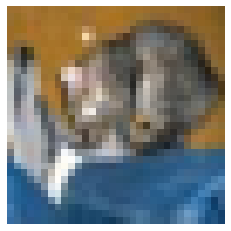

Prediction: cat


In [9]:
from matplotlib import pyplot as plt
image = next(testiter)[0][0]
plt.axis('off')
plt.imshow(image.permute((1, 2, 0)))
plt.show()

pred = predict(resnet34_model, image.unsqueeze(dim=0))  # 由于模型接受的输入shape为4维（第1维为batch_size），因此需要使用unsqueeze函数在图片前面加一维
val_set = torchvision.datasets.CIFAR10(root='../dataset',train=False)
print('Prediction:', val_set.classes[pred])